In [1]:
!nvidia-smi

Thu May 15 15:38:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [3]:
import os

base_dir = path

print(os.listdir(base_dir))
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

print(os.listdir(train_dir))
print(os.listdir(test_dir))

['Training', 'Testing']
['pituitary', 'notumor', 'meningioma', 'glioma']
['pituitary', 'notumor', 'meningioma', 'glioma']


In [4]:
train_image_dir_glioma = os.path.join(train_dir, 'glioma')
train_image_dir_meningioma = os.path.join(train_dir, 'meningioma')
train_image_dir_pituitary = os.path.join(train_dir, 'pituitary')
train_image_dir_no = os.path.join(train_dir, 'notumor')

test_image_dir_glioma = os.path.join(test_dir, 'glioma')
test_image_dir_meningioma = os.path.join(test_dir, 'meningioma')
test_image_dir_pituitary = os.path.join(test_dir, 'pituitary')
test_image_dir_no = os.path.join(test_dir, 'notumor')

print('total training image:', len(os.listdir(train_image_dir_glioma)) + len(os.listdir(train_image_dir_meningioma)) +
      len(os.listdir(train_image_dir_pituitary)) + len(os.listdir(train_image_dir_no)))
print('total testing image:', len(os.listdir(test_image_dir_glioma)) + len(os.listdir(test_image_dir_meningioma)) +
      len(os.listdir(test_image_dir_pituitary)) + len(os.listdir(test_image_dir_no)))
print('total glioma tumor (train):', len(os.listdir(train_image_dir_glioma)))
print('total meningioma tumor (train):', len(os.listdir(train_image_dir_meningioma)))
print('total pituitary tumor (train):', len(os.listdir(train_image_dir_pituitary)))
print('total no tumor (train):', len(os.listdir(train_image_dir_no)))
print('total glioma tumor (test):', len(os.listdir(test_image_dir_glioma)))
print('total meningioma tumor (test):', len(os.listdir(test_image_dir_meningioma)))
print('total pituitary tumor (test):', len(os.listdir(test_image_dir_pituitary)))
print('total no tumor (test):', len(os.listdir(test_image_dir_no)))

total training image: 5712
total testing image: 1311
total glioma tumor (train): 1321
total meningioma tumor (train): 1339
total pituitary tumor (train): 1457
total no tumor (train): 1595
total glioma tumor (test): 300
total meningioma tumor (test): 306
total pituitary tumor (test): 300
total no tumor (test): 405


In [5]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Tiền xử lý cho tập huấn luyện (với data augmentation)
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((512, 512)),  # Thay đổi kích thước
    transforms.RandomHorizontalFlip(p=0.6),  # Lật ngang ngẫu nhiên
    transforms.RandomRotation(degrees=30),  # Xoay ngẫu nhiên ±30 độ
    #transforms.Grayscale(num_output_channels=1),  # Chuyển thành ảnh xám
    transforms.ToTensor(),  # Chuyển thành tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Chuẩn hóa
])

# Tiền xử lý cho tập kiểm tra (không có data augmentation)
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((512, 512)),  # Thay đổi kích thước
    #transforms.Grayscale(num_output_channels=1),  # Chuyển thành ảnh xám
    transforms.ToTensor(),  # Chuyển thành tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Chuẩn hóa
])

# Áp dụng vào ImageFolder
train_data = ImageFolder(train_dir, transform=train_transforms)
test_data = ImageFolder(test_dir, transform=test_transforms)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

train = DataLoader(train_data, batch_size=32, shuffle=True)
test = DataLoader(test_data, batch_size=32, shuffle=True)

dataiter = iter(train)
images, labels = next(dataiter)
print(f"Shape of input batch: {images.shape}")

Shape of input batch: torch.Size([32, 1, 512, 512])


In [8]:
import torch
import torch.nn as nn
from torchvision import models

# Load model
vgg16 = models.vgg16(pretrained=True)
# Convert input layer
vgg16.features[0] = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

for param in vgg16.features.parameters():
    param.requires_grad = False  # Không cập nhật trọng số các lớp tiền huấn luyện

num_classes = 4
vgg16.classifier[6] = nn.Linear(4096, num_classes)

vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes)
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 147MB/s]


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=1e-4)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 1/10 - Train Loss: 0.0207 Train Acc: 73.51% | Val Loss: 0.0166 Val Acc: 77.42% | Training time: 244.69 seconds
Epoch 2/10 - Train Loss: 0.0135 Train Acc: 82.81% | Val Loss: 0.0145 Val Acc: 82.07% | Training time: 206.23 seconds
Epoch 3/10 - Train Loss: 0.0118 Train Acc: 84.44% | Val Loss: 0.0113 Val Acc: 85.58% | Training time: 203.42 seconds
Epoch 4/10 - Train Loss: 0.0107 Train Acc: 87.22% | Val Loss: 0.0093 Val Acc: 87.95% | Training time: 203.28 seconds
Epoch 5/10 - Train Loss: 0.0097 Train Acc: 88.24% | Val Loss: 0.0128 Val Acc: 83.45% | Training time: 205.40 seconds
Epoch 6/10 - Train Loss: 0.0084 Train Acc: 89.46% | Val Loss: 0.0105 Val Acc: 87.95% | Training time: 204.20 seconds
Epoch 7/10 - Train Loss: 0.0075 Train Acc: 91.00% | Val Loss: 0.0080 Val Acc: 90.08% | Training time: 204.62 seconds
Epoch 8/10 - Train Loss: 0.0072 Train Acc: 91.30% | Val Loss: 0.0075 Val Acc: 90.47% | Training time: 203.34 seconds
Epoch 9/10 - Train Loss: 0.0070 Train Acc: 91.75% | Val Loss: 0.

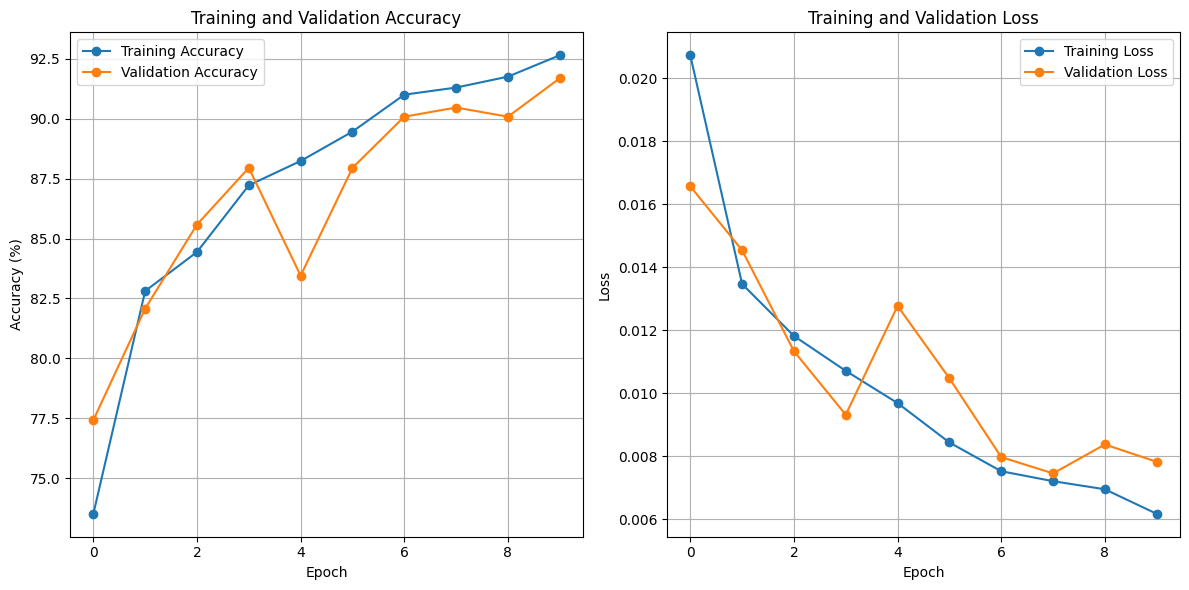

In [11]:
import time
import matplotlib.pyplot as plt

num_epochs = 10
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

for epoch in range(num_epochs):
    start_time = time.time()

    vgg16.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train:
        images = images.to(device)
        labels = labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward
        outputs = vgg16(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Thống kê
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)

        # Nếu labels là one-hot, chuyển về chỉ số lớp
        if labels.ndim == 2:
            true_labels = torch.argmax(labels, dim=1)
        else:
            true_labels = labels

        total += labels.size(0)
        correct += (predicted == true_labels).sum().item()

    train_accuracy = 100 * correct / total
    avg_loss = running_loss / len(train.dataset)

    # ---------- Validation ----------
    vgg16.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in test:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = vgg16(val_images)
            v_loss = criterion(val_outputs, val_labels)
            val_loss += v_loss.item()

            _, val_pred = torch.max(val_outputs, 1)

            if val_labels.ndim == 2:
                val_true = torch.argmax(val_labels, dim=1)
            else:
                val_true = val_labels

            val_total += val_labels.size(0)
            val_correct += (val_pred == val_true).sum().item()

    val_accuracy = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(test.dataset)

    train_acc_history.append(train_accuracy)
    val_acc_history.append(val_accuracy)
    train_loss_history.append(avg_loss)
    val_loss_history.append(avg_val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Train Loss: {avg_loss:.4f} Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} Val Acc: {val_accuracy:.2f}% | "
          f"Training time: {epoch_time:.2f} seconds")

plt.figure(figsize=(12, 6))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Training Accuracy', marker='o')
plt.plot(val_acc_history, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Training Loss', marker='o')
plt.plot(val_loss_history, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Lưu trọng số mô hình đã huấn luyện
torch.save(vgg16, 'VGG16_Brain_Tumor.pth')  # Lưu toàn bộ mô hình
torch.save(vgg16.state_dict(), 'VGG16_Brain_Tumor_para.pth')  # Chỉ lưu trọng số